# MHZ19B sensor qualification


In [25]:
import requests
import numpy as np
from scipy import signal
import pandas as pd

## Material & method

### Experimental setup

The MHZ19B CO2 sensor can be polled using RS line and dedicated protocol as defined in [specifications][1].

We have build a generic driver for this sensor and preformed a light assessment (not rigorous) of sensor properties.

[1]: https://www.winsen-sensor.com/d/files/infrared-gas-sensor/mh-z19b-co2-ver1_0.pdf

### Experimental data

All data are publically available from the [Grafana][1] service either using the dashboard or the API.

[1]: https://landercy.be/grafana/d/njMG-VFGz/mhz19b-co2-monitoring?orgId=1&from=1601075202523&to=1601285606709

#### Events

We fetch experiment events table:

In [2]:
rep = requests.get("https://landercy.be/grafana/api/annotations?dashboardId=11")
tags = pd.json_normalize(rep.json())[["id", "time", "timeEnd", "text", "tags"]]
tags = tags.rename({"time": "start", "timeEnd": "stop"}, axis=1)
for k in ['start', 'stop']:
    tags[k] = pd.to_datetime(tags[k], origin='unix', unit='ms')
tags = tags.sort_values(["start", "stop"]).explode('tags')
tags.tail()

,id,start,stop,text,tags
35,547,2020-09-27 17:39:46.909,2020-09-27 17:39:46.909,Start real monitoring,real
39,558,2020-09-27 19:27:15.424,2020-09-27 19:27:15.424,Door opened,real
34,546,2020-09-27 21:39:41.290,2020-09-27 21:39:41.290,New API version released on ARM7,NaN
37,555,2020-09-28 08:11:34.367,2020-09-28 08:11:34.367,Window opened,real
38,556,2020-09-28 09:02:16.307,2020-09-28 09:02:16.307,Stop real monitoring,real


Noticiable events are:

In [3]:
tags = tags.loc[~tags['tags'].isnull()]
tags

,id,start,stop,text,tags
15,520,2020-09-26 16:26:09.475,2020-09-26 16:36:15.754,Span,span
16,521,2020-09-26 16:36:07.981,2020-09-26 16:51:01.854,Sample,sample
17,522,2020-09-26 17:17:27.507,2020-09-26 17:24:58.330,Span,span
18,523,2020-09-26 17:25:21.648,2020-09-26 17:36:45.655,Zero,zero
19,524,2020-09-26 17:37:08.974,2020-09-26 17:44:47.569,Span,span
14,518,2020-09-26 18:26:16.343,2020-09-27 00:35:34.839,Container leak,leak
13,517,2020-09-27 02:42:37.002,2020-09-27 07:24:31.584,Container leak,leak
21,526,2020-09-27 07:25:55.190,2020-09-27 07:40:29.176,Zero,zero
22,527,2020-09-27 07:40:39.337,2020-09-27 07:54:27.324,Sample,sample
24,531,2020-09-27 07:55:48.107,2020-09-27 08:48:02.627,Zero air,zero


#### Sensor data

We fetch sensor data from the Grafana API:

In [4]:
rep = requests.get("https://landercy.be/grafana/api/datasources/proxy/7/query", params={
    "db": "udlog_mhz19b",
    "q": "SELECT * FROM \"default\""
})
ser = rep.json()['results'][0]['series'][0]
data = pd.DataFrame(ser['values'], columns=ser['columns']).set_index('time')
data = data.drop(['checked_sum', 'identifier'], axis=1)
data.index = pd.to_datetime(data.index).tz_localize(None)
data = data.resample('15s').mean()
data

,checked_count,value_max,value_mean,value_median,value_min,value_std
time,,,,,,
2020-09-25 23:43:15,5.0,748.000000,747.900000,748.000000,747.5,0.223607
2020-09-25 23:43:30,5.0,749.666667,749.533333,749.666667,749.0,0.298142
2020-09-25 23:43:45,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-25 23:44:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-25 23:44:15,3.0,750.000000,750.000000,750.000000,750.0,NaN
...,...,...,...,...,...,...
2020-09-28 09:02:00,15.0,582.000000,581.533333,582.000000,581.0,0.516398
2020-09-28 09:02:15,15.0,581.000000,580.666667,581.000000,580.0,0.487950
2020-09-28 09:02:30,15.0,583.000000,581.933333,582.000000,581.0,0.593617


Graphically it renders as follow:

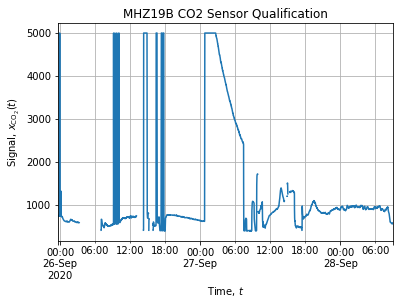

In [5]:
axe = data['value_mean'].plot()
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

## Results & discussion

### Zero & Span

In [6]:
tags[tags['tags'].isin(['zero', 'span'])]#.agg(['min', 'max'])

,id,start,stop,text,tags
15,520,2020-09-26 16:26:09.475,2020-09-26 16:36:15.754,Span,span
17,522,2020-09-26 17:17:27.507,2020-09-26 17:24:58.330,Span,span
18,523,2020-09-26 17:25:21.648,2020-09-26 17:36:45.655,Zero,zero
19,524,2020-09-26 17:37:08.974,2020-09-26 17:44:47.569,Span,span
21,526,2020-09-27 07:25:55.190,2020-09-27 07:40:29.176,Zero,zero
24,531,2020-09-27 07:55:48.107,2020-09-27 08:48:02.627,Zero air,zero
26,534,2020-09-27 09:13:33.875,2020-09-27 09:38:51.850,Zero,zero


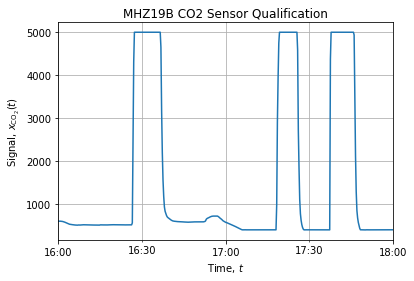

In [7]:
axe = data.loc["2020-09-26 16:00:00":"2020-09-26 18:00:00",'value_mean'].plot()
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

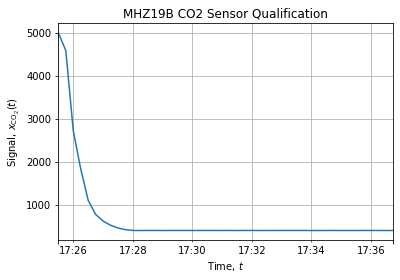

In [8]:
axe = data.loc["2020-09-26 17:25:21":"2020-09-26 17:36:45",'value_mean'].plot()
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

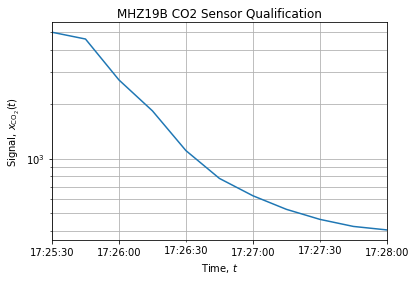

In [9]:
axe = data.loc["2020-09-26 17:25:21":"2020-09-26 17:28:00",'value_mean'].plot(logy=True)
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

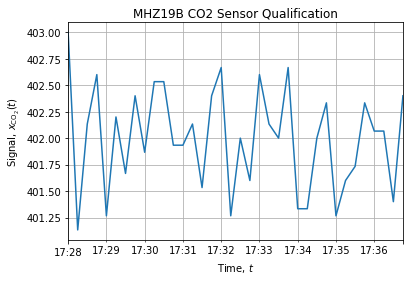

In [10]:
axe = data.loc["2020-09-26 17:28:00":"2020-09-26 17:36:45",'value_mean'].plot()
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

In [11]:
data.loc["2020-09-26 17:28:00":"2020-09-26 17:36:45",'value_mean'].describe()

count     36.000000
mean     402.001852
std        0.488207
min      401.133333
25%      401.600000
50%      402.033333
75%      402.400000
max      403.000000
Name: value_mean, dtype: float64

### Sample


In [12]:
tags[tags['tags'] == 'sample']#.agg(['min', 'max'])

,id,start,stop,text,tags
16,521,2020-09-26 16:36:07.981,2020-09-26 16:51:01.854,Sample,sample
22,527,2020-09-27 07:40:39.337,2020-09-27 07:54:27.324,Sample,sample
25,533,2020-09-27 08:48:24.504,2020-09-27 09:13:03.052,Sample,sample
27,535,2020-09-27 09:38:08.521,2020-09-27 09:49:58.224,Sample,sample


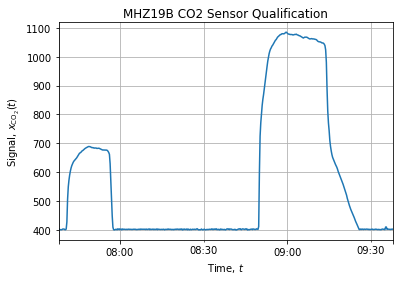

In [13]:
axe = data.loc["2020-09-27 07:38:00":"2020-09-27 09:38:00",'value_mean'].plot()
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

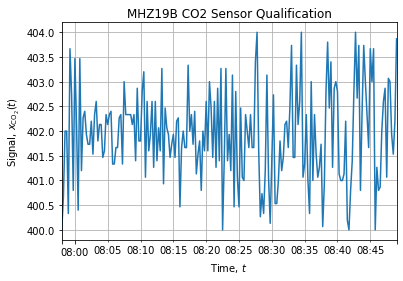

In [14]:
axe = data.loc["2020-09-27 07:58:00":"2020-09-27 08:49:00",'value_mean'].plot()
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

In [15]:
data.loc["2020-09-27 07:58:00":"2020-09-27 08:49:00",'value_mean'].describe()

count    205.000000
mean     401.929431
std        0.922501
min      400.000000
25%      401.266667
50%      401.933333
75%      402.466667
max      404.000000
Name: value_mean, dtype: float64

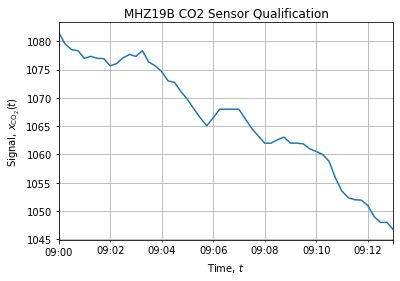

In [16]:
axe = data.loc["2020-09-27 09:00:00":"2020-09-27 09:13:00",'value_mean'].plot()
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

In [17]:
x = data.loc["2020-09-27 09:00:00":"2020-09-27 09:13:00",['value_mean']]
x['value_detrend'] = signal.detrend(x['value_mean'].values)
x['value_detrend'].describe()

count    5.300000e+01
mean    -4.719076e-14
std      2.148231e+00
min     -3.581132e+00
25%     -1.877310e+00
50%     -3.110789e-02
75%      2.085631e+00
max      3.891195e+00
Name: value_detrend, dtype: float64

### Leak

In [18]:
tags[tags['tags'] == 'leak']#.agg(['min', 'max'])

,id,start,stop,text,tags
14,518,2020-09-26 18:26:16.343,2020-09-27 00:35:34.839,Container leak,leak
13,517,2020-09-27 02:42:37.002,2020-09-27 07:24:31.584,Container leak,leak


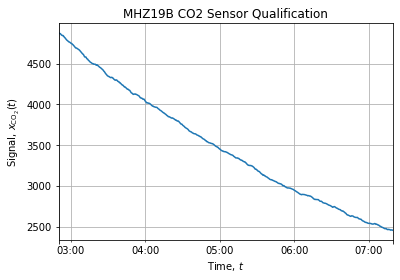

In [23]:
axe = data.loc["2020-09-27 02:50:00":"2020-09-27 07:20:00",'value_mean'].plot()
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

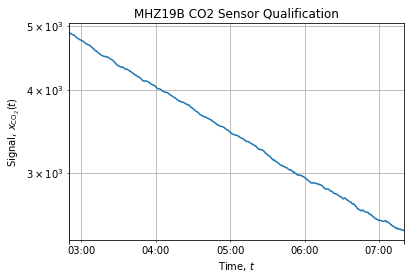

In [31]:
axe = data.loc["2020-09-27 02:50:00":"2020-09-27 07:20:00",'value_mean'].plot(logy=True)
axe.set_title("MHZ19B CO2 Sensor Qualification")
axe.set_xlabel(r"Time, $t$")
axe.set_ylabel(r"Signal, $x_\mathrm{CO_2}(t)$")
axe.grid(which='both')

<AxesSubplot:xlabel='time'>

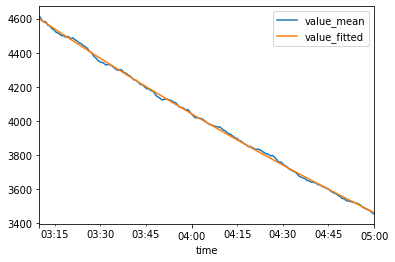

In [80]:
x = data.loc["2020-09-27 03:10:00":"2020-09-27 05:00:00",['value_mean']]
t = pd.to_timedelta(x.index - x.index[0]).total_seconds()
p = np.polyfit(t, np.log(x['value_mean'].values), 1)
x['value_fitted'] = np.exp(t*p[0]+p[1])
x['abs_error'] = x['value_mean'] - x['value_fitted']
x['rel_error'] = x['abs_error']/x['value_fitted']
x[['value_mean', 'value_fitted']].plot()

In [81]:
x['abs_error'].describe()

count    441.000000
mean       0.003404
std        9.067160
min      -21.645969
25%       -5.609104
50%       -0.427096
75%        5.847746
max       22.764860
Name: abs_error, dtype: float64

<AxesSubplot:ylabel='Density'>

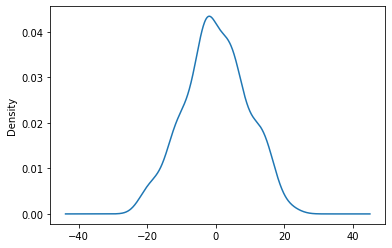

In [82]:
x['abs_error'].plot(kind='kde')

<AxesSubplot:xlabel='time'>

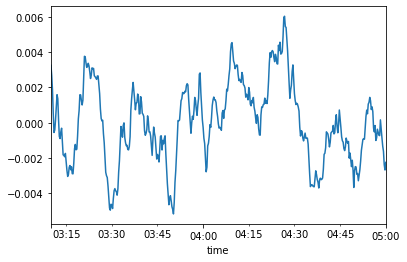

In [84]:
x['rel_error'].plot()